<a href="https://colab.research.google.com/github/ByteBoss-ai/smart-expense-categorizer/blob/main/Smart_Expense_Categorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libraries
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import joblib
import os

random.seed(42)
np.random.seed(42)

# Build Synthetic Datasets

In [3]:
# Define spending categories and their corresponding merchant names
categories = {
    "Food": ["Swiggy", "Zomato", "Dominos", "Pizza Hut", "KFC", "Cafe Coffee Day", "Starbucks", "Burger King"],
    "Travel": ["Uber", "Ola", "Metro", "Indian Rail", "Bus", "Flight", "Taxi", "Auto"],
    "Grocery": ["BigBasket", "DMart", "Reliance Fresh", "Grofers", "Nature's Basket", "Spencer's"],
    "Shopping": ["Amazon", "Flipkart", "Myntra", "Ajio", "Lifestyle", "Shoppers Stop"],
    "Bills": ["Electricity Bill", "Water Board", "Phone Bill", "BSNL", "Airtel Bill", "Jio"],
    "Entertainment": ["Netflix", "Spotify", "Prime Video", "BookMyShow", "Cinema", "Disney+"],
    "Health": ["Apollo Pharmacy", "1mg", "MedPlus", "Clinic", "Hospital", "Pharmacy"],
    "Education": ["Coursera", "Udemy", "Unacademy", "BYJU'S", "College Fees", "Library Fine"],
    "Fuel": ["HP Petrol", "IndianOil", "Bharat Petroleum", "Shell", "Fuel"],
    "Others": ["Donation", "Rent", "Salary", "Refund", "Insurance", "Courier"]
}

In [4]:
# Define text templates to simulate real-world transaction descriptions
templates = [
    "{merchant} {amt}",
    "{merchant} payment {amt}",
    "{merchant} order #{oid} - {amt}",
    "{merchant} - {amt} INR",
    "{merchant} UPI {amt}",
    "{merchant} POS {amt}",
    "{merchant} debit {amt}",
    "{merchant} credit {amt}",
    "{merchant} bill {amt}",
    "{merchant} recharge {amt}"
]

In [5]:
# Initialize empty list to store our synthetic data
rows = []

In [6]:
# Generate synthetic dataset by iterating through each category
for cat, merchants in categories.items():
    for _ in range(60):  # 60 samples per category
        # Randomly select merchant from the category
        merchant = random.choice(merchants)
        # Generate random amount between 20 and 5000
        amt = random.randint(20, 5000)
        # Generate random order ID for templates to use it
        oid = random.randint(100, 9999)
        # Select a random template format
        template = random.choice(templates)
        # Format the transaction text using the template
        text = template.format(merchant=merchant, amt=amt, oid=oid)

     # Adding realistic noise/variations to make data more authentic:
        # 15% chance to add POS terminal information
        if random.random() < 0.15:
            text = text + " - POS 1234"
        # 10% chance to add payment prefix
        if random.random() < 0.10:
            text = "Paid to " + text
        # 5% chance to convert to lowercase (simulating inconsistent data entry)
        if random.random() < 0.05:
            text = text.lower()

        # Add generated text and category to dataset
        rows.append((text, cat))

In [7]:
# Create DataFrame from the generated data
df = (
    pd.DataFrame(rows, columns=["text", "category"])
    .sample(frac=1, random_state=42)   # Shuffle the dataset randomly
    .reset_index(drop=True)            # Reset index after shuffling
)

In [8]:
# Print dataset statistics
print("Dataset size:", df.shape)  # Should show (600, 2) - 600 samples, 2 columns
print(df['category'].value_counts())  # Show distribution of categories (should be 60 each)

Dataset size: (600, 2)
category
Travel           60
Health           60
Others           60
Shopping         60
Bills            60
Food             60
Education        60
Entertainment    60
Fuel             60
Grocery          60
Name: count, dtype: int64


# Train/test split

In [9]:
# Extract features and labels from the dataframe
X = df['text'].values
y = df['category'].values
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42, stratify=y)

# Pipeline (TF-IDF + Logistic Regression)

In [10]:
# Creating a machine learning pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ('clf', LogisticRegression(max_iter=2000, C=1.0))
])
# Train the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=2000))])

# 4) Evaluation

In [11]:
# Generate predictions on the test
y_pred = pipeline.predict(X_test)
# Calculate and print overall accuracy
print('\nTest accuracy:', accuracy_score(y_test, y_pred))
# Print detailed classification report with various metrics
print('\nClassification report:\n')
print(classification_report(y_test, y_pred, digits=4))


Test accuracy: 1.0

Classification report:

               precision    recall  f1-score   support

        Bills     1.0000    1.0000    1.0000        11
    Education     1.0000    1.0000    1.0000        10
Entertainment     1.0000    1.0000    1.0000        11
         Food     1.0000    1.0000    1.0000        11
         Fuel     1.0000    1.0000    1.0000        11
      Grocery     1.0000    1.0000    1.0000        11
       Health     1.0000    1.0000    1.0000        11
       Others     1.0000    1.0000    1.0000        11
     Shopping     1.0000    1.0000    1.0000        10
       Travel     1.0000    1.0000    1.0000        11

     accuracy                         1.0000       108
    macro avg     1.0000    1.0000    1.0000       108
 weighted avg     1.0000    1.0000    1.0000       108



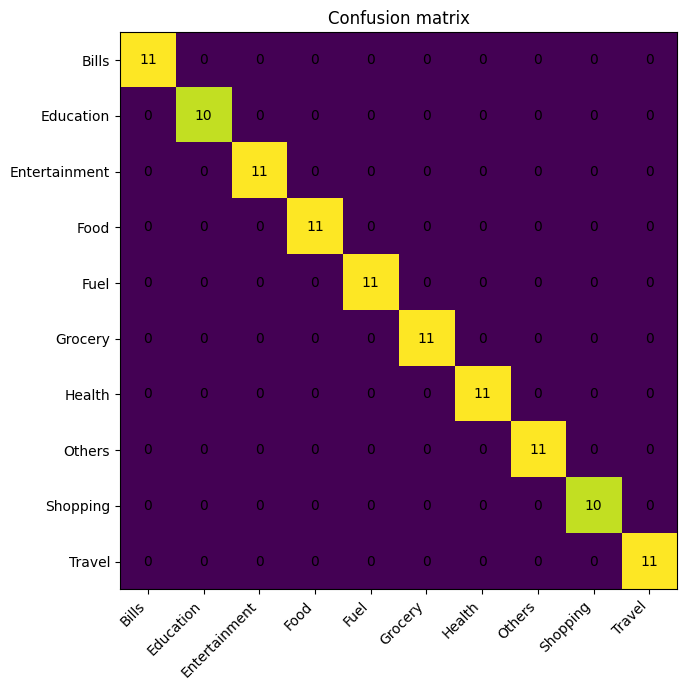

In [12]:
# Generate confusion matrix to visualize model performance
cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
plt.figure(figsize=(9,7))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
labels = sorted(set(y_test))
plt.xticks(np.arange(len(labels)), labels, rotation=45, ha='right')
plt.yticks(np.arange(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i,j], 'd'), ha='center', va='center')
plt.tight_layout()
plt.show()

In [13]:
# Inspect top features per class
vectorizer = pipeline.named_steps['tfidf']  # Get TF-IDF from pipeline
clf = pipeline.named_steps['clf']           # Get classifier from pipeline

In [14]:
def top_features_per_class(clf, vectorizer, top_n=8):
    """Get top predictive words for each category"""
    feature_names = vectorizer.get_feature_names_out()  # All words/ngrams
    coefs = clf.coef_                                   # LR coefficients per class
    classes = clf.classes_                              # Category names

    result = {}
    for idx, c in enumerate(classes):
        # Find indices of top features (highest positive coefficients)
        top_idx = np.argsort(coefs[idx])[-top_n:][::-1]
        # Convert indices to actual words
        result[c] = [feature_names[i] for i in top_idx]
    return result

In [15]:
# Get top 10 features per category
tf_top = top_features_per_class(clf, vectorizer, top_n=10)

In [16]:
# Display results
for cat, feats in tf_top.items():
    print(f"\nTop features for {cat}: \n", feats)


Top features for Bills: 
 ['jio', 'bsnl', 'bill', 'airtel bill', 'airtel', 'phone bill', 'phone', 'board', 'water', 'water board']

Top features for Education: 
 ['unacademy', 'udemy', 'coursera', 'byju', 'library fine', 'library', 'fine', 'college fees', 'fees', 'college']

Top features for Entertainment: 
 ['bookmyshow', 'spotify', 'netflix', 'cinema', 'disney', 'netflix debit', 'prime video', 'prime', 'video', 'disney debit']

Top features for Food: 
 ['zomato', 'swiggy', 'kfc', 'starbucks', 'dominos', 'burger king', 'king', 'burger', 'coffee day', 'coffee']

Top features for Fuel: 
 ['shell', 'fuel', 'indianoil', 'petroleum', 'bharat petroleum', 'bharat', 'petrol', 'hp', 'hp petrol', 'shell credit']

Top features for Grocery: 
 ['dmart', 'spencer', 'grofers', 'bigbasket', 'nature', 'basket', 'nature basket', 'reliance fresh', 'fresh', 'reliance']

Top features for Health: 
 ['pharmacy', 'medplus', 'clinic', '1mg', 'hospital', 'apollo', 'apollo pharmacy', 'pharmacy recharge', '1mg 

# Save the pipeline

In [17]:
out_path = 'expense_categorizer_pipeline.joblib'
joblib.dump(pipeline, out_path)
print('\nSaved trained pipeline to', out_path)


Saved trained pipeline to expense_categorizer_pipeline.joblib


# Sample predictions

In [18]:
samples = [
    "Swiggy order 250 - POS 1234",
    "Uber 300",
    "Amazon 1200",
    "Electricity Bill 1500",
    "BigBasket 900",
    "Netflix payment 199",
    "Apollo Pharmacy 650",
    "HP Petrol 2400",
    "Donation 500",
    "Udemy course 799"
]

In [19]:
probs = pipeline.predict_proba(samples)
preds = pipeline.predict(samples)

In [20]:
for s,p,prob in zip(samples, preds, probs.max(axis=1)):
    print(f"{s}  -> {p} (prob {prob:.3f})")

Swiggy order 250 - POS 1234  -> Food (prob 0.451)
Uber 300  -> Travel (prob 0.552)
Amazon 1200  -> Shopping (prob 0.689)
Electricity Bill 1500  -> Bills (prob 0.587)
BigBasket 900  -> Grocery (prob 0.582)
Netflix payment 199  -> Entertainment (prob 0.547)
Apollo Pharmacy 650  -> Health (prob 0.736)
HP Petrol 2400  -> Fuel (prob 0.779)
Donation 500  -> Others (prob 0.566)
Udemy course 799  -> Education (prob 0.739)
